# Career Path and Skill Analysis

### Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/jobs_with_clusters_v1.csv")

/tmp/ipython-input-2276588260.py:4: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/jobs_with_clusters_v1.csv")


### Parse Skills

In [2]:
df["skills_norm"] = df["skills_norm"].apply(
    lambda x: eval(x) if isinstance(x, str) else []
)

### Filter Rows

In [3]:
df = df[
    (df["skills_norm"].apply(len) > 0) &
    df["job_cluster"].notna() &
    df["salary_final"].notna()
]

### Get Median Salaries

In [4]:
median_salary = (
    df.groupby("job_cluster")["salary_final"]
    .median()
    .sort_values(ascending=False)
)

median_salary

,salary_final
job_cluster,
7,105000.00
0,87500.00
4,75000.00
3,70000.00
2,61055.00
8,45000.00
5,45.13
1,25.00
6,17.82


### Skill Distribution per Archetype

In [5]:
df_exploded = df.explode("skills_norm")

In [6]:
skill_counts = (
    df_exploded
    .groupby(["job_cluster", "skills_norm"])
    .size()
    .reset_index(name="count")
)

#### Normalize proportions

In [7]:
total_per_cluster = skill_counts.groupby("job_cluster")["count"].transform("sum")
skill_counts["proportion"] = skill_counts["count"] / total_per_cluster

### Build Target Skill Profile (Archetype 7)

In [8]:
target_cluster = 7 # Software and AI

target_skills = (
    skill_counts[skill_counts["job_cluster"] == target_cluster]
    .set_index("skills_norm")["proportion"]
)

### Compute Skill Transition Gaps

In [9]:
def compute_transition_gap(source_cluster):
    source_skills = (
        skill_counts[skill_counts["job_cluster"] == source_cluster]
        .set_index("skills_norm")["proportion"]
    )

    gap = (target_skills - source_skills).dropna()
    gap = gap.sort_values(ascending=False)
    return gap


### Visualize Transition Skills

#### Example Archetype 4 → Archetype 7

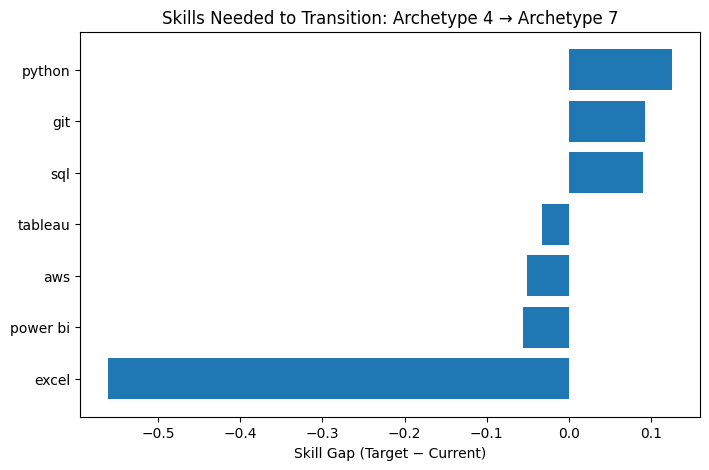

In [10]:
source_cluster = 4
skill_gap = compute_transition_gap(source_cluster)

top_gap = skill_gap.head(15)

plt.figure(figsize=(8,5))
plt.barh(top_gap.index, top_gap.values)
plt.xlabel("Skill Gap (Target − Current)")
plt.title("Skills Needed to Transition: Archetype 4 → Archetype 7")
plt.gca().invert_yaxis()
plt.show()


### For Other Archetypes

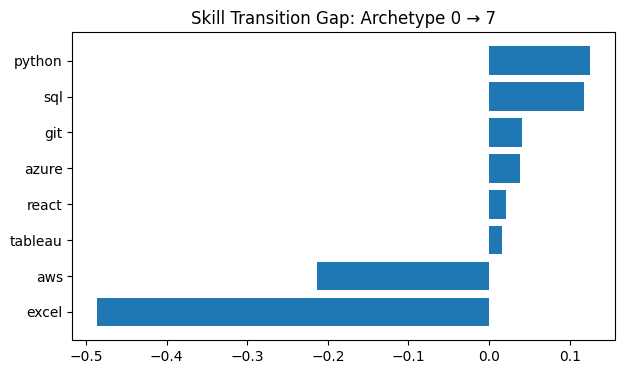

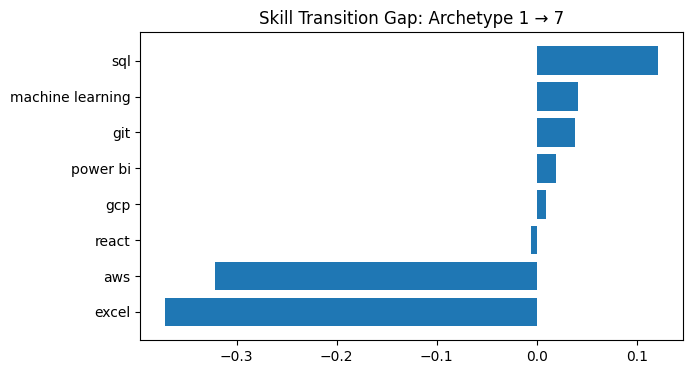

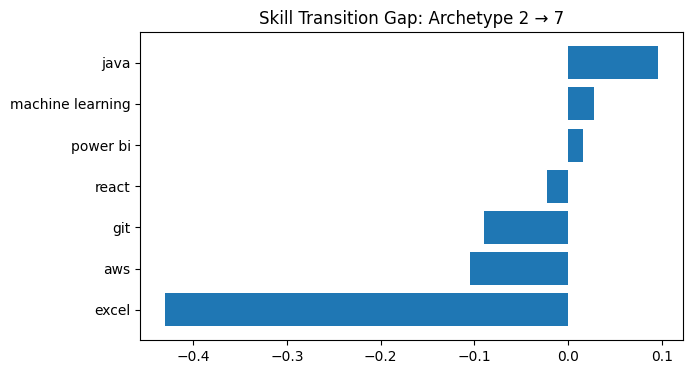

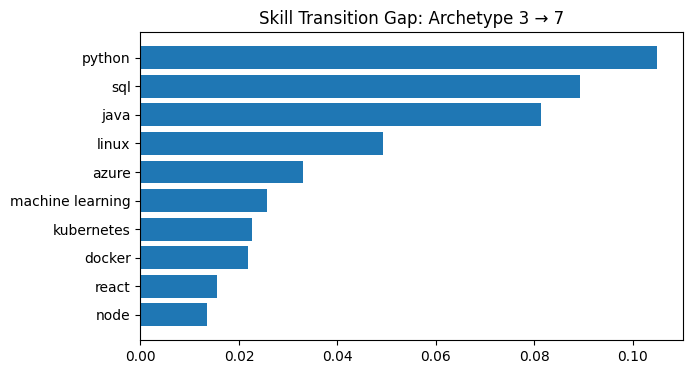

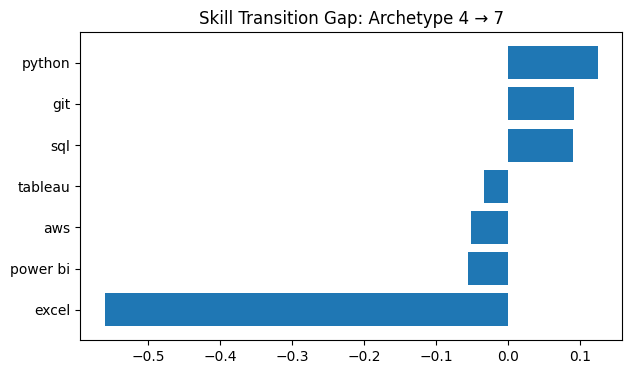

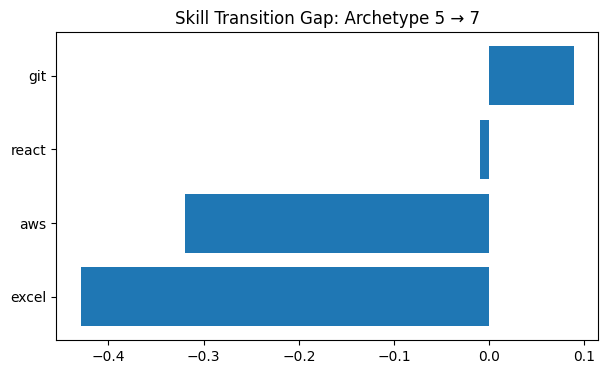

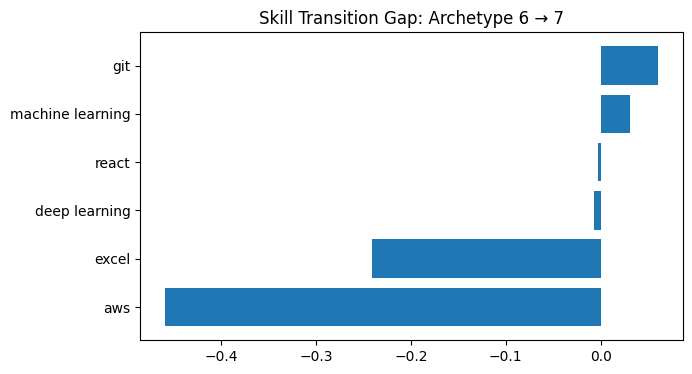

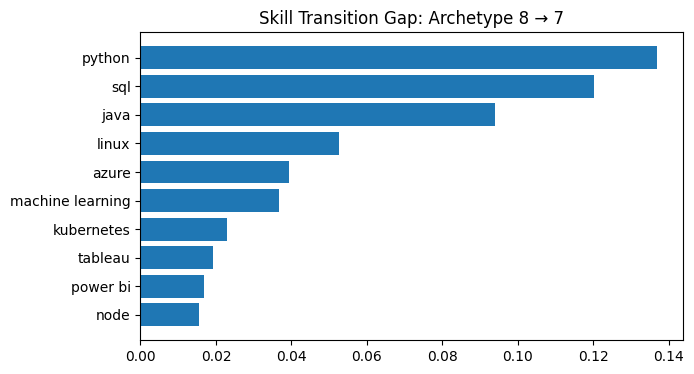

In [11]:
for cluster in sorted(df["job_cluster"].unique()):
    if cluster == target_cluster:
        continue

    gap = compute_transition_gap(cluster).head(10)

    plt.figure(figsize=(7,4))
    plt.barh(gap.index, gap.values)
    plt.title(f"Skill Transition Gap: Archetype {cluster} → {target_cluster}")
    plt.gca().invert_yaxis()
    plt.show()

### Save Transition Table

In [12]:
all_gaps = []

for cluster in sorted(df["job_cluster"].unique()):
    if cluster == target_cluster:
        continue

    gap = compute_transition_gap(cluster)
    gap_df = gap.reset_index()
    gap_df.columns = ["skill", "gap"]
    gap_df["from_cluster"] = cluster
    gap_df["to_cluster"] = target_cluster
    all_gaps.append(gap_df)

transition_df = pd.concat(all_gaps)
transition_df.to_csv("career_skill_transitions_v1.csv", index=False)


## Interpretation Skill Transition Type 4 → 7

**What this plot shows**

- The chart compares skill prevalence in Archetype 4 (Accounting & Finance) against Archetype 7 (Software / Data roles).

- Positive values = skills missing in Archetype 4 but important for Archetype 7.

- Negative values = skills overrepresented in Archetype 4 and less critical for Archetype 7.

**Key insights**

- Core transition skills: python, git, and sql show the largest positive gaps, making them the primary upskilling requirements to move into software/data roles.

- Cloud exposure (aws) and analytics tooling (power bi, tableau) act as secondary bridge skills, helpful but not sufficient alone.

- Excel dominates Archetype 4 but is heavily overrepresented and does not translate well into Archetype 7, signaling a hard skill ceiling without technical upskilling.

**Conclusion**

- Transitioning from finance/accounting roles into software/data roles requires a shift from spreadsheet-centric work to programming, version control, and data querying skills.

- This validates a non-linear career jump that cannot be achieved through domain experience alone.